# 3) NeuralBOW & Facebook Fasttext

## Load Dataset and Variables

In [1]:
import pandas as pd
import pickle

In [2]:
# Load the data

major_dialog_data = pd.read_pickle("./datasets/major_dialog_data.pkl")
all_dialog_data = pd.read_pickle("./datasets/all_dialog_data.pkl")

with open('./datasets/utterances.pkl', 'rb') as f:
    utterances = pickle.load(f)
    
with open('./datasets/stop_words.pkl', 'rb') as f:
    stop_words = pickle.load(f)

# Pre-process the data similarly to workbook 0

labels = major_dialog_data.speaker

speaker_value_counts = all_dialog_data.speaker.value_counts()
major_speaker_value_counts = speaker_value_counts[speaker_value_counts > 40]
x, y = major_speaker_value_counts.index, major_speaker_value_counts.values

num_major_characters = 6

# a list of the top characters names
major_characters = x[:num_major_characters]
# a set of those same names
major_characters_set = set(major_characters)

# finally, dicts to and from class Ids and their respective names
labels_to_ids = {}
ids_to_labels = {}
for i, major_character in enumerate(major_characters):
    labels_to_ids[major_character] = i
    ids_to_labels[i] = major_character
labels_to_ids

{'Rachel': 0, 'Ross': 1, 'Chandler': 2, 'Monica': 3, 'Joey': 4, 'Phoebe': 5}

## Model - Facebook Fasttext
[https://arxiv.org/abs/1607.01759](https://arxiv.org/abs/1607.01759)

This is a simple model with a word embedding layer followed by one hidden fully-connected layer. For this model, we'll train our own embeddings with an embedding dimension of 10. By training the embeddings from scratch, we might achieve more tailored embeddings for this particular corpus. We also use our own vocabulary. We'll include all words that appear in the training corpus 3 or more times.

In [3]:
import math
import models.fasttext as fasttext
import numpy as np
import re
import string
import tensorflow as tf

from collections import Counter, defaultdict
from datetime import datetime
from importlib import reload
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, classification_report
from util import shuffle, batch_iter, conf_matrix_plot

reload(fasttext)

<module 'models.fasttext' from '/home/ec2-user/SageMaker/w266-final/analysis/models/fasttext.py'>

In [4]:
counter = Counter()
stemmer = PorterStemmer()

# manully tokenize the sentences
custom_tokenized = []
for utterance in major_dialog_data.utterance:
    words = re.findall(r"[a-z0-9']+", utterance.lower())
    # remove dangling apostrophes and 's at the end of words
    words = [re.sub(r"'s?$", "", stemmer.stem(word)) for word in words]
    custom_tokenized.append(words)

# count all the tokens
for utterance in custom_tokenized:
    counter.update(word for word in utterance if word not in string.punctuation)

# filter to words of counts greater than 2
vocab = [k for k, v in counter.most_common() if v > 2]

# assign IDs to the words
vocab_word_to_id = defaultdict(lambda: -1)
vocab_id_to_word = {}
for i, word in enumerate(vocab):
    vocab_id_to_word[i] = word
    vocab_word_to_id[word] = i

In [5]:
train_cut = math.ceil(major_dialog_data.utterance.count() * 0.85)

label_ids = np.array([labels_to_ids[label] for label in labels])
train_x_fasttext = custom_tokenized[:train_cut]
train_y_fasttext = label_ids[:train_cut]
test_x_fasttext = custom_tokenized[train_cut:]
test_y_fasttext = label_ids[train_cut:]

train_x_fasttext = np.array([" ".join(words) for words in train_x_fasttext])
test_x_fasttext = np.array([" ".join(words) for words in test_x_fasttext])

In [6]:
tf.reset_default_graph()
fasttext_model = fasttext.FastText(vocab, num_major_characters, regularize_coef=0.1)

In [7]:
display_step = 20
num_epochs = 40
batch_size = 128

train_writer = tf.summary.FileWriter("./fasttext-board/train")
test_writer = tf.summary.FileWriter("./fasttext-board/test")
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    train_writer.add_graph(sess.graph)
    
    global_step = 0
    X = fasttext_model.X
    Y = fasttext_model.Y

    for epoch in range(num_epochs):
        print("{} epoch number: {}".format(datetime.now(), epoch + 1))
        train_x_fasttext, train_y_fasttext = shuffle(train_x_fasttext, train_y_fasttext)
        
        for step, x_batch, y_batch in batch_iter(train_x_fasttext, train_y_fasttext, batch_size):
            global_step += 1
            sess.run(fasttext_model.train_op, feed_dict={ X: x_batch, Y: y_batch })

            # every so often, report the progress of our loss and training accuracy
            if step % display_step == 0:
                summ = sess.run(fasttext_model.merged_summary, feed_dict={ X: x_batch, Y: y_batch })
                train_writer.add_summary(summ, global_step=global_step)
                train_writer.flush()

        test_acc, summ = sess.run([fasttext_model.accuracy, fasttext_model.merged_summary], feed_dict={ X: test_x_fasttext, Y: test_y_fasttext })
        test_writer.add_summary(summ, global_step=global_step)
        test_writer.flush()
        print("test accuracy = {:.4f}".format(test_acc))
    
    # save the model to disk so we can load it up later for use by `./eval.py`
    saver.save(sess, "./fasttext-ckpt/model.ckpt")

2018-12-06 05:18:48.631321 epoch number: 1
test accuracy = 0.1896
2018-12-06 05:18:50.595171 epoch number: 2
test accuracy = 0.1990
2018-12-06 05:18:51.585721 epoch number: 3
test accuracy = 0.1875
2018-12-06 05:18:52.573506 epoch number: 4
test accuracy = 0.1871
2018-12-06 05:18:53.560026 epoch number: 5
test accuracy = 0.1894
2018-12-06 05:18:54.619364 epoch number: 6
test accuracy = 0.1946
2018-12-06 05:18:55.617190 epoch number: 7
test accuracy = 0.1911
2018-12-06 05:18:56.624187 epoch number: 8
test accuracy = 0.1933
2018-12-06 05:18:57.712127 epoch number: 9
test accuracy = 0.2085
2018-12-06 05:18:58.695477 epoch number: 10
test accuracy = 0.2029
2018-12-06 05:18:59.682297 epoch number: 11
test accuracy = 0.2172
2018-12-06 05:19:00.671562 epoch number: 12
test accuracy = 0.2253
2018-12-06 05:19:01.653015 epoch number: 13
test accuracy = 0.2247
2018-12-06 05:19:02.649150 epoch number: 14
test accuracy = 0.2335
2018-12-06 05:19:03.704087 epoch number: 15
test accuracy = 0.2351
2018

This model is only slightly better. It looks like training embeddings from scratch doesn't help.

### FastText Evaluation

INFO:tensorflow:Restoring parameters from ./fasttext-ckpt/model.ckpt
             precision    recall  f1-score   support

     Rachel       0.28      0.44      0.34      1296
       Ross       0.24      0.36      0.29      1193
   Chandler       0.25      0.20      0.22      1195
     Monica       0.25      0.25      0.25      1146
       Joey       0.28      0.22      0.25      1092
     Phoebe       0.34      0.03      0.05       989

avg / total       0.27      0.26      0.24      6911



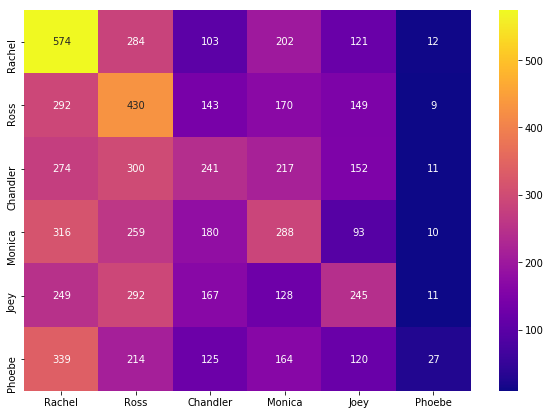

In [8]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "./fasttext-ckpt/model.ckpt")
    sess.run(tf.tables_initializer())
    fasttext_test_preds = sess.run(fasttext_model.predictions, feed_dict={ fasttext_model.X: test_x_fasttext })
    
print(classification_report(test_y_fasttext, fasttext_test_preds, target_names=major_characters))

conf_matrix_plot(confusion_matrix(test_y_fasttext, fasttext_test_preds), major_characters)

## Model - General NeuralBOW

This leverages the model written for Assignment 2 on the television dataset to see if we can improve our accuracy

In [14]:
import math
import models.neuralbow as neuralbow
import nltk
import numpy as np
import os, sys
import tensorflow as tf

from collections import Counter, defaultdict
from datetime import datetime
from importlib import reload
from nltk import word_tokenize
from w266_common import utils, vocabulary

reload(neuralbow)
# Downloading below dataset in order to use word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
character_counts = Counter()
for character in all_dialog_data.speaker:
    character_counts[character] += 1
    
top_characters = character_counts.most_common(6)

char_id_to_word = dict(enumerate([w for w, c in top_characters]))
char_word_to_id = {v:k for k,v in char_id_to_word.items()}

major_dialog_data = all_dialog_data[all_dialog_data.speaker.isin(char_word_to_id.keys())]

utterance_tokenized = [word_tokenize(sentence) for sentence in major_dialog_data.utterance]
vocab = vocabulary.Vocabulary(utils.canonicalize_word(w) for w in utils.flatten(utterance_tokenized))

In [16]:
max_len = 40

utterances_index = [vocab.words_to_ids(words) for words in utterance_tokenized]
speaker_index = np.array([char_word_to_id[speaker] for speaker in major_dialog_data.speaker])
utterances_index_nparray = np.zeros((len(utterances_index), max_len), dtype=np.int32)
utterances_length = np.zeros([len(utterances_index)], dtype=np.int32)

for i, row in enumerate(utterances_index):
    cpy_len = min(len(row), max_len)
    utterances_index_nparray[i,:cpy_len] = row[:cpy_len]
    utterances_length[i] = cpy_len
    
train_cut = math.ceil(major_dialog_data.utterance.count() * 0.6)
dev_cut = math.ceil(major_dialog_data.utterance.count() * 0.8)

train_x = utterances_index_nparray[:train_cut]
train_ns = utterances_length[:train_cut]
train_y = speaker_index[:train_cut]

dev_x = utterances_index_nparray[train_cut:dev_cut]
dev_ns = utterances_length[train_cut:dev_cut]
dev_y = speaker_index[train_cut:dev_cut]

test_x = utterances_index_nparray[dev_cut:]
test_ns = utterances_length[dev_cut:]
test_y = speaker_index[dev_cut:]

In [17]:
print(utterances_index_nparray.shape)
print(utterances_length.shape)
print(speaker_index.shape)

(46079, 40)
(46079,)
(46079,)


In [26]:
model_params = dict(V=vocab.size,
                    embed_dim=35,
                    hidden_dims=[15, 10],
                    num_classes=6,
                    encoder_type='bow',
                    lr=0.1,
                    optimizer='adagrad',
                    beta=0.01,
                    dropout_rate=0.05)

checkpoint_dir = "/tmp/tf_bow_sst_" + datetime.now().strftime("%Y%m%d-%H%M")
if os.path.isdir(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

model = tf.estimator.Estimator(model_fn=neuralbow.classifier_model_fn, 
                               params=model_params,
                               model_dir=checkpoint_dir)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tf_bow_sst_20181206-0544', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f06e3c0c358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [27]:
train_params = dict(batch_size=32,
                    total_epochs=40,
                    eval_every=5)

assert(train_params['total_epochs'] % train_params['eval_every'] == 0)

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"ids": train_x,
       "ns": train_ns},
    y=train_y,
    batch_size=train_params['batch_size'], 
    num_epochs=train_params['eval_every'], shuffle=True)

dev_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"ids": dev_x,
       "ns": dev_ns},
    y=dev_y,
    batch_size=128,
    num_epochs=1,
    shuffle=False)

for _ in range(train_params['total_epochs'] // train_params['eval_every']):
    model.train(input_fn=train_input_fn)
    eval_metrics = model.evaluate(input_fn=dev_input_fn, name="dev")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tf_bow_sst_20181206-0544/model.ckpt.
INFO:tensorflow:loss = 2.3399684, step = 1
INFO:tensorflow:global_step/sec: 201.048
INFO:tensorflow:loss = 2.0680788, step = 101 (0.499 sec)
INFO:tensorflow:global_step/sec: 369.511
INFO:tensorflow:loss = 1.9692333, step = 201 (0.271 sec)
INFO:tensorflow:global_step/sec: 385.823
INFO:tensorflow:loss = 1.9007235, step = 301 (0.259 sec)
INFO:tensorflow:global_step/sec: 383.087
INFO:tensorflow:loss = 1.834133, step = 401 (0.261 sec)
INFO:tensorflow:global_step/sec: 382.107
INFO:tensorflow:loss = 1.8295995, step = 501 (0.262 sec)
INFO:tensorflow:global_step/sec: 383.364
INFO:tensorflow:loss = 1.8364763, step = 601 (0.261 sec)
INFO:tensorflow:global_step/sec: 381.585
INFO

In [28]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"ids": test_x,
       "ns": test_ns},
    y=test_y,
    batch_size=128,
    num_epochs=1,
    shuffle=False
)

eval_metrics = model.evaluate(input_fn=test_input_fn, name="test")

print("Accuracy on test set: {:.02%}".format(eval_metrics['accuracy']))
eval_metrics

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-05:46:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_bow_sst_20181206-0544/model.ckpt-34560
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-05:46:19
INFO:tensorflow:Saving dict for global step 34560: accuracy = 0.18795443, cross_entropy_loss = 1.788557, global_step = 34560, loss = 1.7886993
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 34560: /tmp/tf_bow_sst_20181206-0544/model.ckpt-34560
Accuracy on test set: 18.80%


{'accuracy': 0.18795443,
 'cross_entropy_loss': 1.788557,
 'loss': 1.7886993,
 'global_step': 34560}